### Create a dataset with samples from three categories: cofee, tea and water

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Create data
N  = 200
c1 = (0.90 + 0.4 * np.random.rand(N), 0.90 + 0.4*np.random.rand(N))
c2 = (0.60 + 0.4 * np.random.rand(N), 0.60 + 0.4*np.random.rand(N))
c3 = (0.30 + 0.4 * np.random.rand(N), 0.30 + 0.4*np.random.rand(N))

data    = (c1, c2, c3)
colors  = ("red", "green", "blue")
classes = ("class1", "class2", "class3")

# Create plot
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

for data, color, classes in zip(data, colors, classes):
    x1, x2 = data
    ax.scatter(x1, x2, alpha=0.8, c=color, edgecolors='none', s=50, label=classes)

plt.title('Three classes represented by two random variables')
plt.legend(loc=2)
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

### Separate the samples into training and testing sets

In [2]:
def UnisonShuffling(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X = [] 
Y = []
class1_size = len(c1[0])
for i in range(class1_size):
    X.append((c1[0][i],c1[1][i]))
    Y.append((1,0,0)) 
class2_size = len(c2[0])
for i in range(class2_size):
    X.append((c2[0][i],c2[1][i]))
    Y.append((0,1,0))
class3_size = len(c3[0])
for i in range(class3_size):
    X.append((c3[0][i],c3[1][i]))
    Y.append((0,0,1))
nsamples = class1_size + class2_size + class3_size
X = np.array(X)
Y = np.array(Y)
# Apply shuffle and separate training and testing
Xaux = np.copy(X)
Yaux = np.copy(Y)
X, Y = UnisonShuffling(Xaux,Yaux) 
X_train = X[:nsamples//10]
Y_train = Y[:nsamples//10]
X_test  = X[nsamples//10:nsamples]
Y_test  = Y[nsamples//10:nsamples]

### Create a neural network model for classification and train it

In [3]:
import torch
from torch import nn as nn
import torch.optim as optim

# Define a MLP model with four neurons in the hidden layer and three neurons in the decision layer

class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2, out_features=4, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=4, out_features=3, bias=True)
        )
        self.weights_init()

    def forward(self, x):
        y = self.classifier(x)
        return y

    def weights_init(self):
        for x in self.modules():
            if isinstance(x, nn.Linear):
                torch.nn.init.xavier_uniform_(x.weight.data)
                if (x.bias is not None): 
                    x.bias.data.zero_()

    
# Create the model with cross entropy loss and statistical gradient descendant optimizer

model     = NeuralNet()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

# Print weights and bias
print(model.classifier[0].weight, model.classifier[0].bias)
print(model.classifier[2].weight, model.classifier[2].bias)

NeuralNet(
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=3, bias=True)
  )
)
Parameter containing:
tensor([[-0.4004,  0.6780],
        [ 0.0895,  0.7850],
        [-0.8661, -0.4031],
        [ 0.5113,  0.3356]], requires_grad=True) Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tensor([[-0.5375,  0.5138,  0.4719, -0.6269],
        [ 0.0238, -0.1101, -0.5798, -0.6242],
        [-0.0645, -0.7325,  0.2796,  0.7706]], requires_grad=True) Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


### A suitable weight initialization can speed up convergence. We can set the weights of the four neurons in the first layer as follows. 

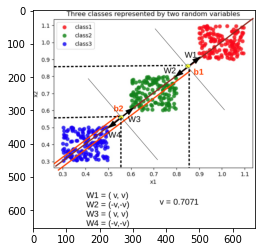

In [4]:
fig = plt.imread('./figs/simple-classification.png')
plt.imshow(fig)
plt.show()

In [5]:
# You can set the weights W1, W2, W3, W4 (orthogonal vectors of the class separation lines above)
# and the biases based on the distances b1 and b2 to the origin. Note that, the NN performs 
# <(x1,x2),Wi> + bias, i=1,2,3,4, then the bias must be -b1 for W1, b1 for W2, -b2 for W3, and b2 for W4. 
# The following lines do that and freeze the dense layer for the training process. If you comment those lines, 
# the training process will estimate the weights of the hidden layer. 

v       = (2.0**0.5)/2
b1      = ((0.85)**2 + (0.85)**2)**0.5
b2      = ((0.55)**2 + (0.55)**2)**0.5
weights = np.array([[v, v], [-v, -v], [v, v], [-v, -v]])
bias    = np.array([-b1, b1, -b2, b2])

# Convert from numpy to tensor
weights = nn.Parameter(torch.from_numpy(weights).float())
bias    = nn.Parameter(torch.from_numpy(bias).float())

# Set weights and bias of the first hidden layer
model.classifier[0].weight.data  = weights
model.classifier[0].bias.data    = bias

# Freeze first hidden layer
for param in model.classifier[0].parameters():
    param.requires_grad = False
    
# Print weights and bias
print(model.classifier[0].weight, model.classifier[0].bias)
print(model.classifier[2].weight, model.classifier[2].bias)    

Parameter containing:
tensor([[ 0.7071,  0.7071],
        [-0.7071, -0.7071],
        [ 0.7071,  0.7071],
        [-0.7071, -0.7071]]) Parameter containing:
tensor([-1.2021,  1.2021, -0.7778,  0.7778])
Parameter containing:
tensor([[-0.5375,  0.5138,  0.4719, -0.6269],
        [ 0.0238, -0.1101, -0.5798, -0.6242],
        [-0.0645, -0.7325,  0.2796,  0.7706]], requires_grad=True) Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


### Train the model

In [6]:
# Convert the training set from numpy to tensor

X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train)

# Train the model

model.train()
epochs   = 100 # if you increase it, then the convergence happens even without forcing the above initialization
corrects = 0
n        = 0
for epoch in range(epochs):
    optimizer.zero_grad() # set gradients to zero
    # Forward pass
    y_pred = model(X_train) 
    corrects   = torch.sum(torch.max(y_pred,1)[1]==torch.max(Y_train,1)[1]).item()
    n          = y_pred.size(0)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), Y_train)
    
    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()
    

# Accuracy after the last epoch    
acc = corrects / n
print('Train acc = ', acc)

Train acc =  0.7333333333333333


### Evaluate the model 

In [7]:
# Convert the test set from numpy to tensor

X_test = torch.FloatTensor(X_test)
Y_test = torch.FloatTensor(Y_test)

# Evaluate the model
model.eval()
y_pred   = model(X_test)
loss     = criterion(y_pred.squeeze(), Y_test)
corrects = torch.sum(torch.max(y_pred,1)[1]==torch.max(Y_test,1)[1]).item()
n        = y_pred.size(0)
print('Test loss' , loss.item(), 'Test acc', corrects/n)

Test loss 0.7901736497879028 Test acc 0.7425925925925926
